<font size = "5"> **Day 1: [Atomic Resolution STEM and Machine Learning](../MLSTEM2025.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />




[Download](https://github.com/gduscher/MLSTEM2025/raw/refs/heads/main/Day%201/3b_Probe.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
   https://colab.research.google.com/github/gduscher/MLSTEM2025/blob/main/Day%201/3b_Probe.ipynb)



# Probe

part of the workshop of 

<font size = "5"> **[Machine Learning in Transmission Electron Microscopy](../MLSTEM2025.ipynb)**</font>


**Day1: Atomic Resolution STEM,**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**May 2025**


## Load packages
### Check for Newest Versions

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.2.3':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q

print('done')

### Load Necessary Packages

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import output
    from google.colab import drive
    output.enable_custom_widget_manager()
    
from matplotlib.patches import Circle

import pyTEMlib
import pyTEMlib.probe_tools
import skimage
import scipy
from skimage.draw import random_shapes


print('pyTEM version: ', pyTEMlib.__version__)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
pyTEM version:  0.2025.03.0


## Goals

Everything we went over so far can be used now to visualize how to determine the aberrations from under and overfocused images.


### Aberration Function $\chi$

Please see this notebook for a more detailed discussion of the [Aberration Function](CH3_03-CTF.ipynb#Aberrations)

With the main aberration coefficients $C_{n,m}$:

Coefficient  Nion | CEOS | Name
 ----------------|------------- | -------------
 $C_{10}$ | $C_1$ |defocus
 $C_{12a}$, $C_{12b}$  | $A_1$ |astigmatism
 $C_{21a}$, $C_{21b}$  | $B_2$ |coma
 $C_{23a}$, $C_{23b}$  | $A_2$ |three-fold astigmatism
 $C_{30}$  | $C_3$ |spherical aberration
    
As before the aberration function $\chi$ in polar coordinates (of angles) $\theta$ and $\phi$ is defined according to [Krivanek et al.](https://doi.org/10.1016/S0304-3991(99)00013-3):

$$
\chi(\theta, \phi) = \sum_n \theta^{n+1} *\frac{1}{n+1} * \sum_{n} C_{n,m,a}  \cos(m*\phi) + C_{n,m,b} \sin(m*\phi) 
$$

with:
- $n$: order ($n=0,1,2,3,...$)
- $m$: symmetry  $m = ..., n+1$;  
    - $m$ is all odd   for n = even
    - $m$ is all even  for n = odd

    

In the following we program the equation above just as seen. The terms are divided into the theta (line 22) and the sum part (line 33).  The product of these two terms is summed in line 39.

We assume that the aberrations are given up to fifth order.




We see that increasing the size of an coherently illuminated aperture is reducing the probe diameter and therefore improving spatial resolution. The goal is to obtain an as large radius as possible of quasi-coherent area (in reciprocal space) match it with an aperture and use that as a probforming configuration.

The Ronchigram will get us that coherent illumination and we will discuss this Ronchigram in detail in this notebook.

## Calculate Ronchigram

Setting up the meshes of angles $\phi$ and $\theta$ in polar coordinates for which the aberrations will be calculated.
This is analog to what we did in the [Ronchigram notebook](./2_berrations).


The effect of defocus $C_{10}$ and astigmatism $C_{12a}$ and $C_{12b}$ on the ronchigram can be explored below.
Also change coma $C_{21a}$ and $C_{21b}$ and spherical aberration  $C_{30}$ or anyother aberration you might want to test.

### Load Aberrations

The aberrations are expected to be in a python dictionary.

Besides the aberration coefficients, 
for the calculation of the aberrations the wavelength and therefore the acceleration voltage is needed.

Here we load the aberration for a microscope: the following microscpes are available:
- ZeissMC200
- NionUS200
- NionUS100

In [2]:

ab = pyTEMlib.probe_tools.get_target_aberrations("ZeissMC200",200000)
ab = pyTEMlib.probe_tools.get_target_aberrations("NionUS200",200000)
#ab = pyTEMlib.probe_tools.get_target_aberrations("NionUS100",60000)
ab = pyTEMlib.probe_tools.get_target_aberrations("Spectra300", 200000)
ab['C10'] = -5
reciprocal_FOV = ab['reciprocal_FOV'] = 150*1e-3
ab['FOV'] = 1/reciprocal_FOV
ab['extent'] = [-reciprocal_FOV*1000,reciprocal_FOV*1000,-reciprocal_FOV*1000,reciprocal_FOV*1000]
ab['size'] = 512
ab['wavelength'] = pyTEMlib.probe_tools.get_wavelength(ab['acceleration_voltage'])

pyTEMlib.probe_tools.print_aberrations(ab)

 **** Using Target Values at 200.0kV for Aberrations of NionUS200****


### Probe Shape Calculation
The probe shape is defined as the absolute of the 
inverse of the aberration function which is limited by an aperture.



In [3]:
ab.update({'A1': [-1.7256467648864592e-09, -4.33652950047942e-09],
  'A2': [1.1832002758281756e-07, -9.356132757317088e-08],
  'C3': [3.9123259711154475e-07, 0.0],
  'C1': [-7.160069847952156e-09, 0.0],
  'A4': [-1.2421582380458277e-06, -6.555555994007509e-07],
  'A3': [9.14858860850468e-08, 8.24581795110536e-08],
  'A5': [2.4305034548402935e-05, -4.3665588715379156e-05],
  'B2': [-3.583665699539742e-08, -7.368501963663006e-08],
  'B4': [2.7117076219729385e-07, 3.745259044319655e-06],
  'S3': [1.892912397258682e-07, -5.2074838081861786e-08],
  'C5': [-1.4203666265095235e-05, 0.0],
  'D4': [-1.0812219869916382e-07, 4.316301635786145e-06],
  'WD': [0.000120721584514962, 2.8815317878038834e-05]},)





0.03
0.03


AttributeError: module 'pyTEMlib.probe_tools' has no attribute 'print_aberrations_polar'

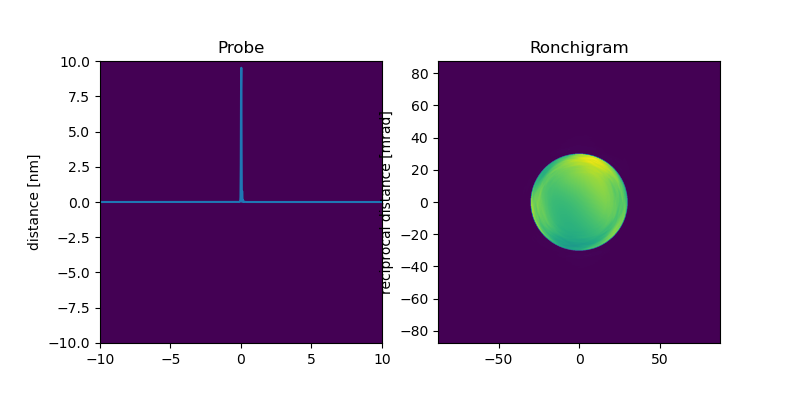

In [4]:
sizeX = 512*2
probe_FOV  = 20
ab['Cc'] = 1
ab['C10'] = 0

ronchi_FOV = 350 #mrad
condensor_aperture_radius =  30  # mrad
ronchi_condensor_aperture_radius = 30  # mrad
ab['FOV'] = probe_FOV
ab['convergence_angle'] = condensor_aperture_radius
probe, A_k, chi  = pyTEMlib.probe_tools.get_probe( ab, sizeX, sizeX,  scale = 'mrad', verbose= True)

ab['FOV'] = 4/ronchi_FOV*sizeX/2 * ab['wavelength'] *1000
ab['convergence_angle'] = ronchi_condensor_aperture_radius ## let have a little bit of a view
ronchigram = pyTEMlib.probe_tools.get_ronchigram(1024, ab, scale = 'mrad'  )

ab['FOV'] = probe_FOV
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(probe, extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)])
ax[0].set_ylabel('distance [nm]')
profile = probe[:, 256]
ax[0].plot(np.linspace(-ab['FOV']/2,ab['FOV']/2,profile.shape[0]), probe[int(probe.shape[1]/2),:]/probe[int(probe.shape[1]/2),:].max()*probe_FOV/2.1)
ax[0].set_title('Probe')
ax[1].imshow(ronchigram, extent = ab['ronchi_extent'])
ax[1].set_ylabel(ab['ronchi_label'])
ax[1].set_title('Ronchigram')
pyTEMlib.probe_tools.print_aberrations_polar(ab)
    
    
#condensor_aperture = Circle((0, 0), radius = condensor_aperture_radius)#, fill = False, color = 'red')
#plt.gca().add_patch(condensor_aperture);

0.03
0.03
0.03


(226.0, 286.0)

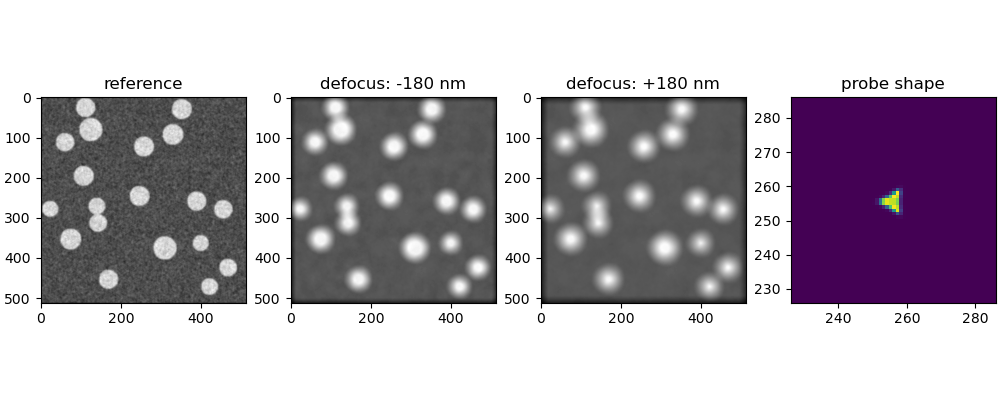

In [5]:
# ---- Input -----
ab['C10'] = 30
ab['C23b'] = 400
ab['C23a'] = -00

ab['C21a'] = -00
ab['C21b'] = -00

# ------------------
def get_probe_large(ab):    
    ab['FOV'] = 20
    sizeX = 512*2
    probe, A_k, chi  = pyTEMlib.probe_tools.get_probe( ab, sizeX, sizeX,  scale = 'mrad', verbose= True)
    
    res = np.zeros((512, 512))
    res[256-32:256+32, 256-32:256+32 ] = skimage.transform.resize(probe, (64, 64))
    
    return res

def get_large_image(number_of_electrons=1000):
    image, _ = random_shapes((512, 512), min_shapes=15, max_shapes=26, shape='circle',
                             min_size=40, max_size = 60, allow_overlap=False, num_channels=1)
    image = 1-np.squeeze(image)/image.max()
    image[image<.1] = 0
    image[image>0] = number_of_electrons
    noise = np.random.poisson(image)
    image = image+noise+np.random.random(image.shape)*noise.max()
    return image
     
def large_image (ab, image=None, FOV=15*4) :
    out = np.zeros([3, image.shape[0], image.shape[1]])
    C10 = ab['C10'] 
    ab['C10'] = C10-180
    res = get_probe_large(ab)
    out[1] = scipy.signal.fftconvolve(image, res, mode='same') 

    ab['C10'] = C10+180
    res = get_probe_large(ab)
    out[2] = scipy.signal.fftconvolve(image, res, mode='same') 
    
    ab['C10'] = C10
    res = get_probe_large(ab)
    out[0] = scipy.signal.fftconvolve(image, res, mode='same') 
    
    return out, res
    

image = get_large_image(number_of_electrons=10)

imaged, res = large_image(ab, image, 90)
image *= 1000/image.max()

fig, axs = plt.subplots(1, 4, layout='constrained', figsize=(10, 4))

axs[0].imshow(imaged[0], cmap='gray')
axs[0].set_title('reference')
axs[1].imshow(imaged[1], cmap='gray')
axs[1].set_title('defocus: -180 nm')
axs[2].imshow(imaged[2], cmap='gray')

axs[2].set_title('defocus: +180 nm')
axs[3].imshow(res)

axs[3].set_title('probe shape')
axs[3].set_ylim(256-30,256+30)
axs[3].set_xlim(256-30,256+30)


## Determine Probe Shape from Images
A Deconvolution of the defocused images from the reference image will determine the probe shape.

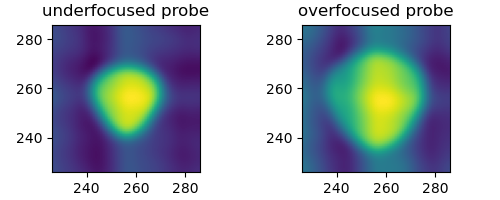

In [6]:
def get_probe_shape_from_images(images):
    im1 = np.fft.fft2(np.array(images[0]))
    im2 = np.fft.fft2(np.array(images[1]))
    im3 = np.fft.fft2(np.array(images[2]))
    g1 = np.fft.fft2(pyTEMlib.probe_tools.make_gauss(512,512,3))

    dec = np.zeros([2, im1.shape[0], im1.shape[1]])
    dec[0] = np.fft.ifft2(g1*(im2/im1).T).real
    dec[1] = np.fft.ifft2(g1*(im3/im1).T).real

    return dec

dec = get_probe_shape_from_images(imaged)

fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(5, 2))

axs[0].imshow(dec[0])
axs[0].set_title('underfocused probe')
axs[0].set_ylim(256-30,256+30)
axs[0].set_xlim(256-30,256+30)

axs[1].imshow(dec[1])
axs[1].set_title('overfocused probe')
axs[1].set_ylim(256-30,256+30)
axs[1].set_xlim(256-30,256+30)

pyTEMlib.probe_tools.print_aberrations(ab)

In the image above look for differences in size and the shape.

A defocus of the reference image should result in different sized defocused probes.

A three-fold astigmatis $C_{23}$ or A2 should give a triangular probe.



## Probe Shape in polar coordinates

To analyse the probe shape a simple line detection is possible in polar coordinates

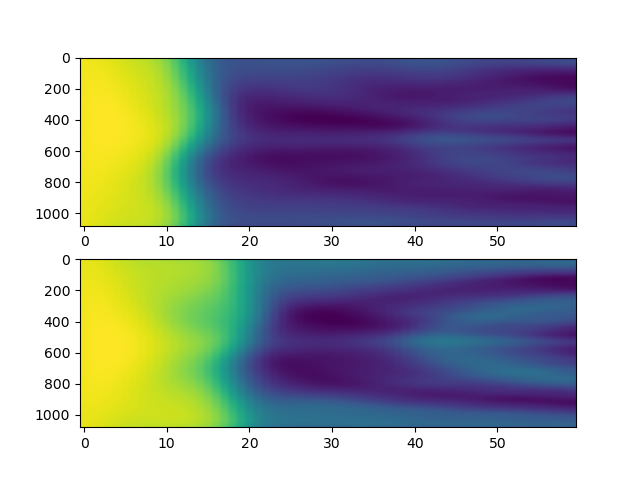

In [7]:
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates


def cartesian2polar(x, y, grid, r, t, order=3):

    R,T = np.meshgrid(r, t)

    new_x = R*np.cos(T)
    new_y = R*np.sin(T)

    ix = interp1d(x, np.arange(len(x)))
    iy = interp1d(y, np.arange(len(y)))

    new_ix = ix(new_x.ravel())
    new_iy = iy(new_y.ravel())

    
    return map_coordinates(grid, np.array([new_ix, new_iy]),
                            order=order).reshape(new_x.shape)

def warp(diff,center=None):
    # Define original polar grid
    nx = diff.shape[0]
    ny = diff.shape[1]
    if center is None:
        center = [int(diff.shape[0]/2), int(diff.shape[1]/2)]

    x = np.linspace(1, nx, nx, endpoint = True)-center[0]
    y = np.linspace(1, ny, ny, endpoint = True)-center[1]
    z = diff

    # Define new polar grid
    nr = int(min([center[0], center[1], diff.shape[0]-center[0], diff.shape[1]-center[1]])-1)
   
    nt = 360*3


    r = np.linspace(1, nr, nr)
    t = np.linspace(0., np.pi, nt, endpoint = False)
    return cartesian2polar(x, y, z, r, t, order=3).T

polar_beam_under = warp(dec[0].real)
polar_beam_over = warp(dec[1].real)

plt.figure()
plt.subplot(211)
plt.imshow(polar_beam_under.T[:,:60], aspect='auto')

plt.subplot(212)
plt.imshow(polar_beam_over.T[:,:60], aspect='auto')

## Conclusions

We need a high-contrast sample for the tableau based determination of aberrations.

Known under and over-focused images with the reference image will allow for a deconvolution of the probe shape.

We use the larger probe size of the defocused beam and the fact that defocus $C_{1,0}$ does not influence any other aberrations.